In [1]:
import os
from pathlib import Path
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

In [2]:
#config = {'BATCH_SIZE':128,'NUM_EPOCHS':5}
model = LeNet5(n_classes=10)
train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/MNIST/raw



In [3]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)

In [4]:
import numpy as np

def train_epoch(epoch, ds, model, criterion, optimizer, scheduler):
  model.train()
  total = 0
  correct = 0
  train_loss = 0

  for i, (inputs, targets) in enumerate(ds):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    if scheduler is not None:
        scheduler.step()

  train_loss = train_loss / len(ds)
  accuracy = correct/total

  print(f'Epoch {epoch}: Loss: {train_loss} Batch Accuracy: {accuracy}')
  return {'train_loss': train_loss, 'train_accuracy': accuracy}

def evaluate(ds, model, criterion):
  model.eval()
  total = 0
  correct = 0
  test_loss = 0

  with torch.no_grad():
    for i, (inputs, targets) in enumerate(ds):
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

    test_loss = test_loss/len(ds)
    accuracy = correct/total

    print(f'Test Set evaluation: Loss: {test_loss} Test Accuracy: {accuracy}')
    return {'test_loss': test_loss, 'test_accuracy': accuracy}

def train(train_ds, test_ds, optimizer, model, epochs=30, scheduler=None):
  criterion = nn.CrossEntropyLoss()
  history_data = []
  for i in tqdm(range(epochs)):
    train_stats = train_epoch(i, train_ds, model, criterion, optimizer, scheduler)
    test_stats = evaluate(test_ds, model, criterion)
    history_data.append((train_stats, test_stats, optimizer.param_groups[0]['lr']))
  return history_data

In [5]:
import matplotlib.pyplot as plt
def plot_history_data(history, figname=None):
  lrs = [h[2] for h in history]
  train_loss = [h[0]['train_loss'] for h in history]
  train_accuracy = [h[0]['train_accuracy'] for h in history]

  test_loss = [h[1]['test_loss'] for h in history]
  test_accuracy = [h[1]['test_accuracy'] for h in history]
  
  fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,16))
  ax1.plot(lrs)
  ax1.set(yscale='log', xlabel='Epoch', ylabel='Learning Rate')

  ax2.plot(train_loss, label='train_loss')
  ax2.plot(test_loss, label='test_loss')
  ax2.legend()
  ax2.set(xlabel='Epoch', ylabel='Loss')

  ax3.plot(train_accuracy, label='train_accuracy')
  ax3.plot(test_accuracy, label='test_accuracy')
  ax3.legend()
  ax3.set(xlabel='Epoch', ylabel='Accuracy')

  plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: Loss: 1.2116058275008252 Batch Accuracy: 0.6642333333333333


  3%|▎         | 1/30 [00:27<13:11, 27.30s/it]

Test Set evaluation: Loss: 0.38636302306682246 Test Accuracy: 0.8927
Epoch 1: Loss: 0.32340505452298407 Batch Accuracy: 0.9071666666666667


  7%|▋         | 2/30 [00:52<12:11, 26.14s/it]

Test Set evaluation: Loss: 0.25016942768817463 Test Accuracy: 0.9274
Epoch 2: Loss: 0.22548570236099807 Batch Accuracy: 0.9332333333333334


 10%|█         | 3/30 [01:17<11:32, 25.63s/it]

Test Set evaluation: Loss: 0.17449280003062154 Test Accuracy: 0.9475
Epoch 3: Loss: 0.16622202518556925 Batch Accuracy: 0.9522833333333334


 13%|█▎        | 4/30 [01:42<10:59, 25.36s/it]

Test Set evaluation: Loss: 0.13023062002008098 Test Accuracy: 0.9631
Epoch 4: Loss: 0.13078846502056254 Batch Accuracy: 0.9617333333333333


 17%|█▋        | 5/30 [02:07<10:29, 25.18s/it]

Test Set evaluation: Loss: 0.10857966421407801 Test Accuracy: 0.9696
Epoch 5: Loss: 0.1077546472194543 Batch Accuracy: 0.96895


 20%|██        | 6/30 [02:32<10:02, 25.09s/it]

Test Set evaluation: Loss: 0.08981026934247606 Test Accuracy: 0.9732
Epoch 6: Loss: 0.09176021385818783 Batch Accuracy: 0.97335


 23%|██▎       | 7/30 [02:57<09:38, 25.17s/it]

Test Set evaluation: Loss: 0.07683933189704636 Test Accuracy: 0.9766
Epoch 7: Loss: 0.08134944023671689 Batch Accuracy: 0.9764166666666667


 27%|██▋       | 8/30 [03:22<09:13, 25.15s/it]

Test Set evaluation: Loss: 0.067934673650874 Test Accuracy: 0.9778
Epoch 8: Loss: 0.07263385557702609 Batch Accuracy: 0.9795833333333334


 30%|███       | 9/30 [03:47<08:48, 25.14s/it]

Test Set evaluation: Loss: 0.06191670721620793 Test Accuracy: 0.9807
Epoch 9: Loss: 0.0659714077613247 Batch Accuracy: 0.98165


 33%|███▎      | 10/30 [04:12<08:20, 25.04s/it]

Test Set evaluation: Loss: 0.05634404210185137 Test Accuracy: 0.982
Epoch 10: Loss: 0.060741024770970535 Batch Accuracy: 0.9823833333333334


 37%|███▋      | 11/30 [04:37<07:53, 24.95s/it]

Test Set evaluation: Loss: 0.05556895842928958 Test Accuracy: 0.9822
Epoch 11: Loss: 0.05676284121440799 Batch Accuracy: 0.98385


 40%|████      | 12/30 [05:02<07:27, 24.86s/it]

Test Set evaluation: Loss: 0.051124263408923926 Test Accuracy: 0.9829
Epoch 12: Loss: 0.05393097219643181 Batch Accuracy: 0.9847166666666667


 43%|████▎     | 13/30 [05:26<07:01, 24.79s/it]

Test Set evaluation: Loss: 0.051362537893855684 Test Accuracy: 0.9834
Epoch 13: Loss: 0.05048941014441791 Batch Accuracy: 0.9858833333333333


 47%|████▋     | 14/30 [05:51<06:36, 24.76s/it]

Test Set evaluation: Loss: 0.04690326545446451 Test Accuracy: 0.9855
Epoch 14: Loss: 0.04806644020518705 Batch Accuracy: 0.9867333333333334


 50%|█████     | 15/30 [06:16<06:11, 24.73s/it]

Test Set evaluation: Loss: 0.04485375380078684 Test Accuracy: 0.9854
Epoch 15: Loss: 0.045815803885046864 Batch Accuracy: 0.9871166666666666


 53%|█████▎    | 16/30 [06:40<05:46, 24.74s/it]

Test Set evaluation: Loss: 0.04777452227353012 Test Accuracy: 0.983
Epoch 16: Loss: 0.044100423721767375 Batch Accuracy: 0.9879833333333333


 57%|█████▋    | 17/30 [07:05<05:21, 24.71s/it]

Test Set evaluation: Loss: 0.04221909356898852 Test Accuracy: 0.9857
Epoch 17: Loss: 0.04206370590016373 Batch Accuracy: 0.9885166666666667


 60%|██████    | 18/30 [07:30<04:56, 24.73s/it]

Test Set evaluation: Loss: 0.04277314442722716 Test Accuracy: 0.9854
Epoch 18: Loss: 0.04083371925245184 Batch Accuracy: 0.9888166666666667


 63%|██████▎   | 19/30 [07:55<04:32, 24.74s/it]

Test Set evaluation: Loss: 0.040912891371187435 Test Accuracy: 0.9859
Epoch 19: Loss: 0.0394066534201696 Batch Accuracy: 0.9889166666666667


 67%|██████▋   | 20/30 [08:20<04:07, 24.79s/it]

Test Set evaluation: Loss: 0.03848425514813324 Test Accuracy: 0.9871
Epoch 20: Loss: 0.03763836710207434 Batch Accuracy: 0.9896833333333334


 70%|███████   | 21/30 [08:45<03:43, 24.88s/it]

Test Set evaluation: Loss: 0.04296418651348994 Test Accuracy: 0.9867
Epoch 21: Loss: 0.036450211387643934 Batch Accuracy: 0.9903166666666666


 73%|███████▎  | 22/30 [09:10<03:19, 24.96s/it]

Test Set evaluation: Loss: 0.03849593075905938 Test Accuracy: 0.9885
Epoch 22: Loss: 0.035334228057422236 Batch Accuracy: 0.9907


 77%|███████▋  | 23/30 [09:34<02:54, 24.87s/it]

Test Set evaluation: Loss: 0.0379276830965323 Test Accuracy: 0.9876
Epoch 23: Loss: 0.034333680770290434 Batch Accuracy: 0.9906166666666667


 80%|████████  | 24/30 [09:59<02:29, 24.85s/it]

Test Set evaluation: Loss: 0.03663451182788615 Test Accuracy: 0.9876
Epoch 24: Loss: 0.03358514252196211 Batch Accuracy: 0.9909166666666667


 83%|████████▎ | 25/30 [10:24<02:03, 24.77s/it]

Test Set evaluation: Loss: 0.038466360327151096 Test Accuracy: 0.9879
Epoch 25: Loss: 0.03221525016105744 Batch Accuracy: 0.99165


 87%|████████▋ | 26/30 [10:48<01:38, 24.73s/it]

Test Set evaluation: Loss: 0.03594201099926229 Test Accuracy: 0.9882
Epoch 26: Loss: 0.03163502076918732 Batch Accuracy: 0.9916333333333334


 90%|█████████ | 27/30 [11:13<01:14, 24.70s/it]

Test Set evaluation: Loss: 0.03609944369402254 Test Accuracy: 0.9883
Epoch 27: Loss: 0.030839988284670848 Batch Accuracy: 0.9916


 93%|█████████▎| 28/30 [11:38<00:49, 24.75s/it]

Test Set evaluation: Loss: 0.03509891947327606 Test Accuracy: 0.9884
Epoch 28: Loss: 0.029999920835237958 Batch Accuracy: 0.99205


 97%|█████████▋| 29/30 [12:03<00:24, 24.74s/it]

Test Set evaluation: Loss: 0.03435420780663697 Test Accuracy: 0.9883
Epoch 29: Loss: 0.029390480171746093 Batch Accuracy: 0.9919833333333333


100%|██████████| 30/30 [12:28<00:00, 24.93s/it]

Test Set evaluation: Loss: 0.03424565544236994 Test Accuracy: 0.9889


Test Set evaluation: Loss: 0.03424565544236994 Test Accuracy: 0.9889


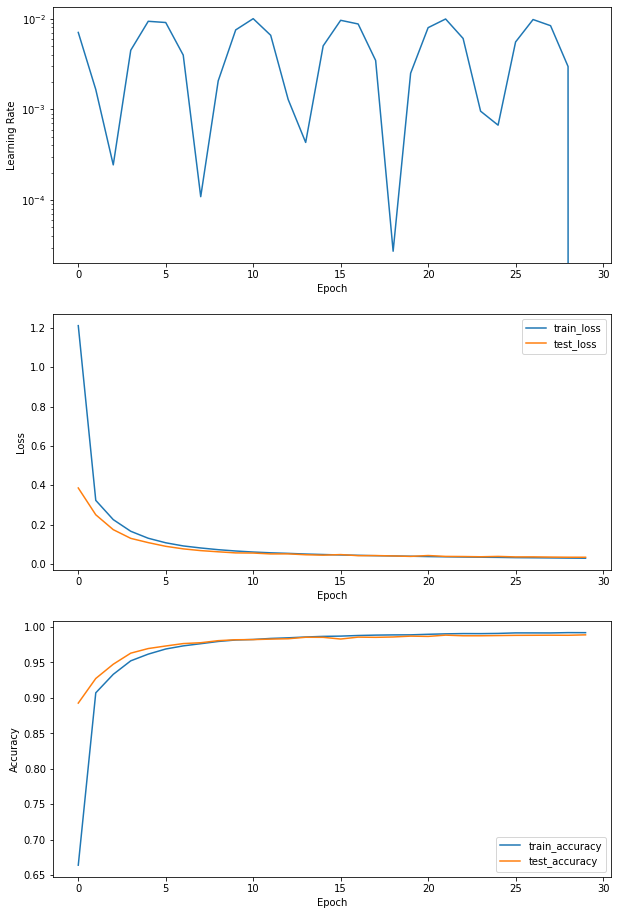

In [6]:
epochs = 30
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
history = train(train_dataloader, test_dataloader, optimizer, model, epochs=epochs, scheduler=scheduler)
evaluate(test_dataloader, model, nn.CrossEntropyLoss())
plot_history_data(history)